In [116]:
import requests
import pandas as pd
import numpy as np
import random
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import urllib.request

# Scraping webpage

In [117]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
table=pd.read_html(url)
table
res = requests.get(" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
raw_data = df[0]

In [118]:
raw_data.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Ignoring rows that has 'Not assigned' values

In [119]:
df_post = data[data.Borough != 'Not assigned']
df_post = df2.sort_values(by = ['Postcode', 'Borough'])

df_post.reset_index(inplace=True)
df_post.drop('index',axis=1,inplace=True)

df_post.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Joining duplicate values

In [120]:
df2 = pd.DataFrame( df_post.groupby(['Postcode','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)]))
df2.reset_index(inplace=True)
df2.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [121]:
df2.shape

(103, 3)

# Geospatial data

In [122]:
geospatial = pd.read_csv('http://cocl.us/Geospatial_data')
geospatial.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [123]:
geospatial.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
geospatial.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# Merging and final Dataframe

In [124]:
final_df = pd.merge(df2, geospatial, on='Postcode')
final_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [125]:
final_df.shape

(103, 5)

In [126]:
final_df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           11
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [127]:
df_toronto = final_df[final_df['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.head()

/Users/finneysunny/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [128]:
df_toronto.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
West Toronto         6
Name: Neighborhood, dtype: int64

# Part-4. Data Analysis and Visualization

In [129]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [130]:
#Toronto coordinates
TORONTO_LAT = 43.70011
TORONTO_LONG = -79.4163

#Foursquare parameters
LIMIT = 100
RADIUS = 500

#Foursquare API URL templates
FS_EXPLORE_URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'

In [131]:
# Sensitive codes
CLIENT_ID = 'T2F2DEHKDLPTJGZWQSKHGYU0J1FLIJEGXHML5FUL4QMSY3JF'
CLIENT_SECRET = 'KKRFFC3UCKR00LBGF3EVUHPDKSORULHLTBMLTA02XIYOH4SZ'
VERSION = '20180604'

In [132]:
toronto_map = folium.Map(location=[TORONTO_LAT, TORONTO_LONG], zoom_start=11)

#add boroughs markers to the map
for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = 'Borough: {}. Neigbourhoods: {}'.format(borough, neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(toronto_map)

In [165]:
toronto_map

### Create function
    1. get_venues()

In [134]:
def get_venues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # API request
        url = FS_EXPLORE_URL.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT) #create the API request URL
        
        # now make GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [135]:
'''def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]'''

'def most_common_venues(row, num_top_venues):\n    row_categories = row.iloc[1:]\n    row_categories_sorted = row_categories.sort_values(ascending=False)    \n    return row_categories_sorted.index.values[0:num_top_venues]'

### Get nearby venues for Toronto neighborhoods

In [136]:
toronto_venues = get_venues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [137]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [138]:
toronto_venues.shape

(1719, 7)

In [139]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,54,54,54,54,54,54
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",48,48,48,48,48,48
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",94,94,94,94,94,94
Christie,17,17,17,17,17,17


In [140]:
toronto_venues['Venue Category'].unique()

array(['Trail', 'Health Food Store', 'Pub', 'Other Great Outdoors',
       'Neighborhood', 'Greek Restaurant', 'Cosmetics Shop',
       'Italian Restaurant', 'Ice Cream Shop', 'Brewery', 'Yoga Studio',
       'Fruit & Vegetable Store', 'Pizza Place', 'Restaurant',
       'Dessert Shop', 'Bookstore', 'Bubble Tea Shop', 'Spa', 'Juice Bar',
       'Furniture / Home Store', 'Diner', 'Grocery Store', 'Coffee Shop',
       'Caribbean Restaurant', 'Indian Restaurant', 'Bakery', 'Lounge',
       'Liquor Store', 'American Restaurant', 'Gym', 'Fish & Chips Shop',
       'Burger Joint', 'Sushi Restaurant', 'Park', 'Pet Store',
       'Burrito Place', 'Steakhouse', 'Movie Theater',
       'Fast Food Restaurant', 'Sandwich Place', 'Board Shop',
       'Intersection', 'Café', 'Cheese Shop', 'Fish Market',
       'Seafood Restaurant', 'Gay Bar', 'Comfort Food Restaurant',
       'Thai Restaurant', 'Middle Eastern Restaurant', 'Stationery Store',
       'Wine Bar', 'Coworking Space', 'Bar', 'Gastropub

In [141]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

True

### One-hot encoding

In [142]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# adding Neighborhood column to toronto_onehot
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# re-arranging columns
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [143]:
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [145]:
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Adelaide, King, Richmond",0.0000,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.02,0.0,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.01
1,Berczy Park,0.0000,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.00,0.0,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.0000,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.0625,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0000,0.0,0.0625,0.0625,0.125,0.1875,0.125,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00


In [146]:
len(toronto_grouped[toronto_grouped["Italian Restaurant"] > 0])

22

In [147]:
italian_res = toronto_grouped[["Neighborhood", "Italian Restaurant"]]

In [148]:
italian_res.head()

,Neighborhood,Italian Restaurant
0,"Adelaide, King, Richmond",0.000000
1,Berczy Park,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.045455
3,Business Reply Mail Processing Centre 969 Eastern,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000


In [149]:
italian_res.shape

(39, 2)

# Clustering

In [150]:
from sklearn.cluster import KMeans

In [151]:
res_clustering = italian_res.drop(["Neighborhood"], 1)

# The elbow method to find the best cluster number
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(res_clustering)
    wcss.append(kmeans.inertia_)

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'The Elbow Method')

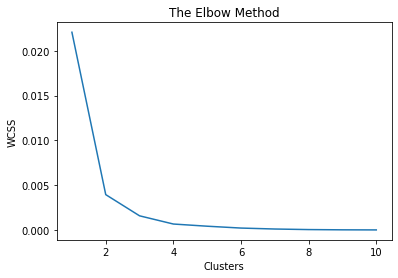

In [153]:
plt.plot(range(1,11), wcss)
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.title("The Elbow Method")

In [182]:
kclusters = 4

# run K-Means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0)
kmeans.fit_transform(res_clustering)

# check cluster labels generated for each row 
kmeans.labels_

array([2, 2, 3, 2, 2, 3, 3, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 1, 2, 3, 3,
       2, 0, 2, 2, 1, 0, 2, 2, 3, 0, 0, 0, 3, 2, 2, 3, 1], dtype=int32)

In [183]:
res_merged = italian_res.copy()

# now add cluster labels to the dataframe
res_merged["Cluster Labels"] = kmeans.labels_

In [184]:
print(res_merged.shape)
res_merged.head()

(39, 3)


,Neighborhood,Italian Restaurant,Cluster Labels
0,"Adelaide, King, Richmond",0.000000,2
1,Berczy Park,0.000000,2
2,"Brockton, Exhibition Place, Parkdale Village",0.045455,3
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,2
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,2


In [185]:
# adding Latitude and Longitude columns to the merged dataframe
res_merged = res_merged.join(toronto_venues.set_index("Neighborhood"), on= "Neighborhood")
res_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",0.0,2,43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall
0,"Adelaide, King, Richmond",0.0,2,43.650571,-79.384568,The Keg Steakhouse & Bar,43.649937,-79.384196,Steakhouse
0,"Adelaide, King, Richmond",0.0,2,43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
0,"Adelaide, King, Richmond",0.0,2,43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
0,"Adelaide, King, Richmond",0.0,2,43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel


In [186]:
res_merged.shape

(1719, 9)

In [187]:
# Sorting as per Cluster Labels
res_merged.sort_values(["Cluster Labels"], inplace=True)
res_merged.head()

,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Church and Wellesley,0.011905,0,43.66586,-79.38316,Ho's Team Barber Shop,43.665630,-79.381359,Salon / Barbershop
9,Church and Wellesley,0.011905,0,43.66586,-79.38316,Si Lom,43.665010,-79.380683,Thai Restaurant
9,Church and Wellesley,0.011905,0,43.66586,-79.38316,FUEL+,43.664399,-79.380427,Juice Bar
9,Church and Wellesley,0.011905,0,43.66586,-79.38316,Coach House Restaurant,43.664991,-79.384814,Diner
9,Church and Wellesley,0.011905,0,43.66586,-79.38316,North of Brooklyn Pizzeria,43.664384,-79.380376,Pizza Place


# Map

In [188]:
only_italian = res_merged.loc[(res_merged["Venue Category"] == "Italian Restaurant")]
only_italian.head()

,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Church and Wellesley,0.011905,0,43.665860,-79.383160,Dal Moro's Fresh Pasta To Go,43.666641,-79.385400,Italian Restaurant
14,"Design Exchange, Toronto Dominion Centre",0.030000,0,43.647177,-79.381576,TOCA,43.645431,-79.387059,Italian Restaurant
14,"Design Exchange, Toronto Dominion Centre",0.030000,0,43.647177,-79.381576,Scaddabush Italian Kitchen & Bar,43.644737,-79.385355,Italian Restaurant
27,Queen's Park,0.026316,0,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
10,"Commerce Court, Victoria Hotel",0.030000,0,43.648198,-79.379817,Carisma,43.649617,-79.375434,Italian Restaurant


In [189]:
LAT = only_italian["Venue Latitude"].mean()
LON = only_italian["Venue Longitude"].mean()

In [190]:
map_cluster = folium.Map(location=[LAT, LON], zoom_start =12)

# colors as per clusters and adding markers to map

marker_color = {}
marker_color[0] = 'red'
marker_color[1] = 'blue'
marker_color[2] = 'green'
marker_color[3] = 'cyan'

for lat, lon, cluster in zip(only_italian['Neighborhood Latitude'], only_italian['Neighborhood Longitude'], only_italian['Cluster Labels']):
    
    folium.CircleMarker(
        [lat, lon],
        radius =5,
        color = marker_color[cluster],
        fill_color= marker_color[cluster],
        fill_opacity= 0.5).add_to(map_cluster)
    
map_cluster

In [177]:
# Cluster 0

df_cluster0 = only_italian.loc[(only_italian['Cluster Labels'] ==0)]
print(df_cluster0.shape)
df_cluster0

(15, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Church and Wellesley,0.011905,0,43.665860,-79.383160,Dal Moro's Fresh Pasta To Go,43.666641,-79.385400,Italian Restaurant
14,"Design Exchange, Toronto Dominion Centre",0.030000,0,43.647177,-79.381576,TOCA,43.645431,-79.387059,Italian Restaurant
14,"Design Exchange, Toronto Dominion Centre",0.030000,0,43.647177,-79.381576,Scaddabush Italian Kitchen & Bar,43.644737,-79.385355,Italian Restaurant
27,Queen's Park,0.026316,0,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
10,"Commerce Court, Victoria Hotel",0.030000,0,43.648198,-79.379817,Carisma,43.649617,-79.375434,Italian Restaurant
14,"Design Exchange, Toronto Dominion Centre",0.030000,0,43.647177,-79.381576,Amano Pasta,43.644919,-79.382358,Italian Restaurant
10,"Commerce Court, Victoria Hotel",0.030000,0,43.648198,-79.379817,Terroni,43.650927,-79.375602,Italian Restaurant
10,"Commerce Court, Victoria Hotel",0.030000,0,43.648198,-79.379817,Mercatto,43.650243,-79.380820,Italian Restaurant
33,Stn A PO Boxes 25 The Esplanade,0.021053,0,43.646435,-79.374846,Carisma,43.649617,-79.375434,Italian Restaurant
23,"Little Portugal, Trinity",0.018519,0,43.647927,-79.419750,Ufficio,43.649439,-79.423014,Italian Restaurant


In [179]:
# Cluster 1

df_cluster1 = only_italian.loc[(only_italian['Cluster Labels'] ==1)]
print(df_cluster1.shape)
df_cluster1

(9, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
18,"Harbord, University of Toronto",0.055556,1,43.662696,-79.400049,Daddyo's,43.664622,-79.402685,Italian Restaurant
26,"Parkdale, Roncesvalles",0.071429,1,43.648960,-79.456325,Domani Restaurant & Wine Bar,43.649235,-79.450229,Italian Restaurant
8,Christie,0.058824,1,43.669542,-79.422564,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
38,"The Danforth West, Riverdale",0.069767,1,43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
38,"The Danforth West, Riverdale",0.069767,1,43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant
38,"The Danforth West, Riverdale",0.069767,1,43.679557,-79.352188,Il Fornello,43.678604,-79.346904,Italian Restaurant
18,"Harbord, University of Toronto",0.055556,1,43.662696,-79.400049,Piano Piano,43.662949,-79.402898,Italian Restaurant
11,Davisville,0.060606,1,43.704324,-79.388790,Positano,43.704558,-79.388639,Italian Restaurant
11,Davisville,0.060606,1,43.704324,-79.388790,Florentia Ristorante,43.703594,-79.387985,Italian Restaurant


In [180]:
# Cluster 2

df_cluster2 = only_italian.loc[(only_italian['Cluster Labels'] ==2)]
print(df_cluster2.shape)
df_cluster2

(1, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,"First Canadian Place, Underground city",0.01,2,43.648429,-79.38228,Mercatto,43.650243,-79.38082,Italian Restaurant


In [181]:
# Cluster 3
df_cluster3 = only_italian.loc[(only_italian['Cluster Labels'] ==3)]
print(df_cluster3.shape)
df_cluster3

(17, 9)


,Neighborhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
20,"Harbourfront East, Toronto Islands, Union Station",0.040000,3,43.640816,-79.381752,Taverna Mercatto,43.642625,-79.383257,Italian Restaurant
20,"Harbourfront East, Toronto Islands, Union Station",0.040000,3,43.640816,-79.381752,Amano Pasta,43.644919,-79.382358,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",0.045455,3,43.636847,-79.428191,Caffino,43.639021,-79.425289,Italian Restaurant
37,"The Beaches West, India Bazaar",0.052632,3,43.668999,-79.315572,Casa di Giorgio,43.666645,-79.315204,Italian Restaurant
34,Studio District,0.046512,3,43.659526,-79.340923,Lil' Baci,43.660512,-79.343151,Italian Restaurant
34,Studio District,0.046512,3,43.659526,-79.340923,Baldini,43.661300,-79.339027,Italian Restaurant
6,Central Bay Street,0.048193,3,43.657952,-79.387383,Tosto,43.661198,-79.386414,Italian Restaurant
6,Central Bay Street,0.048193,3,43.657952,-79.387383,Sambuca Grill,43.656110,-79.392946,Italian Restaurant
30,"Runnymede, Swansea",0.050000,3,43.651571,-79.484450,Goodfellas Wood Oven Pizza,43.648224,-79.486356,Italian Restaurant
30,"Runnymede, Swansea",0.050000,3,43.651571,-79.484450,Campo,43.655191,-79.487067,Italian Restaurant


# Findings

Most number of Italian Restaurants - Clusters 1,2 and 3
Least number of Italian Restaurants - Cluster 0

Area Covered in Cluster 0,1 and 3 are:

**Brockton, Exhibition Place, Parkdale Village, Harbord, University of Toronto,
Harbourfront East, Toronto Islands, Union Station,
High Park, The Junction South, Cabbagetown, St. James Town,
Studio District, The Beaches West, India Bazaar
The Esplanade, Queen's Park,
Ryerson, Garden District, St. James Town,
Commerce Court, Victoria Hotel,
Design Exchange, Toronto Dominion Centre,
Little Portugal, Trinity, Church and Wellesley
The Danforth West, Riverdale, Central Bay Street, Christie,
Runnymede, Swansea, Parkdale, Roncesvalles, Davisville**

Area covered in cluster 2:

**First Canadian Place, Underground City**

So, based on the findings, cluster 2 would be a better place to open an Italian Restaurant.